#### This script creates world maps of cloud bands over the northern hemisphere and southern hemispheres depicing issues of detection when setting up domains not made for cloud band detection over convergence zones 

Importation of appropriate packages

In [1]:
import os, sys
import warnings

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

try:
    import cartopy.crs as ccrs
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    import cartopy.util as cutil
    LON_FORMAT = LongitudeFormatter(zero_direction_label=True, degree_symbol="")
    LAT_FORMAT = LatitudeFormatter(degree_symbol="")
except ModuleNotFoundError:
    print("Cartopy is not installed. Figure will not be produced.")

warnings.filterwarnings("ignore")

dir_package = "../"
sys.path.insert(0, dir_package + "src/cloudbanddetection/")
# from blob_tools import detection_workflow
from figure_tools import set_fontsize
from time_utilities import create_list_of_dates, add_startend_datetime2config

# from utilities import compute_resolution, wrapTo180
from io_utilities import (
    load_ymlfile,
    load_data_from_saved_var_files,
)

Load configuration files and data

In [2]:
# Load configuration file southern hemisphere
config_file = os.path.join(dir_package, "config", "config_cbworkflow_southernhemisphere.yml")
config = load_ymlfile(config_file, isconfigfile=True)

config_copy = config.copy()
config_copy["saved_dirpath"] = os.path.join(dir_package, "data")
config_copy["startdate"] = "20210127.00"
config_copy["enddate"] = "20210127.00"
config_copy["load_saved_files"] = True
add_startend_datetime2config(config_copy)
listofdates = create_list_of_dates(config_copy)

list_of_cloud_bands_southhemisphere = load_data_from_saved_var_files(config=config_copy, varname="list_of_cloud_bands")

# Load configuration file northen hemisphere
config_file2 = os.path.join(dir_package, "config", "config_cbworkflow_northernhemisphere.yml")
config2 = load_ymlfile(config_file2, isconfigfile=True)

config_copy2 = config2.copy()
config_copy2["saved_dirpath"] = os.path.join(dir_package, "data")
config_copy2["startdate"] = "19980627.00"
config_copy2["enddate"] = "19980627.00"
# config_copy2["startdate"] = "19980627.00"
# config_copy2["enddate"] = "19980627.00"
config_copy2["load_saved_files"] = True
add_startend_datetime2config(config_copy2)
listofdates2 = create_list_of_dates(config_copy2)

list_of_cloud_bands_northhemisphere = load_data_from_saved_var_files(
    config=config_copy2, varname="list_of_cloud_bands"
)

In [3]:
# Create longitudes and latitudes of the two hemispheres
lons = np.arange(config["lon_west"], config["lon_east"], 0.5)
lats_sh = np.arange(config["lat_south"], config["lat_north"] + 0.5, 0.5)[::-1]
lats_nh = np.arange(config_copy2["lat_south"], config_copy2["lat_north"] + 0.5, 0.5)

In [4]:
# Load OLR data. It will be the background of the cloud bands on the maps
filename_sh = f"../data/olrERA5_{config_copy['datetime_startdate'].strftime('%Y%m%d.%H')}-{config_copy['datetime_enddate'].strftime('%Y%m%d.%H')}-{config_copy['domain']}.npy"
daily_variable_sh = np.load(filename_sh)[0]
daily_variable_sh, clons = cutil.add_cyclic_point(daily_variable_sh, lons)

filename_nh = f"../data/olrERA5_{config_copy2['datetime_startdate'].strftime('%Y%m%d.%H')}-{config_copy2['datetime_enddate'].strftime('%Y%m%d.%H')}-{config_copy2['domain']}.npy"
daily_variable_nh = np.load(filename_nh)[0]
daily_variable_nh, _ = cutil.add_cyclic_point(daily_variable_nh, lons)

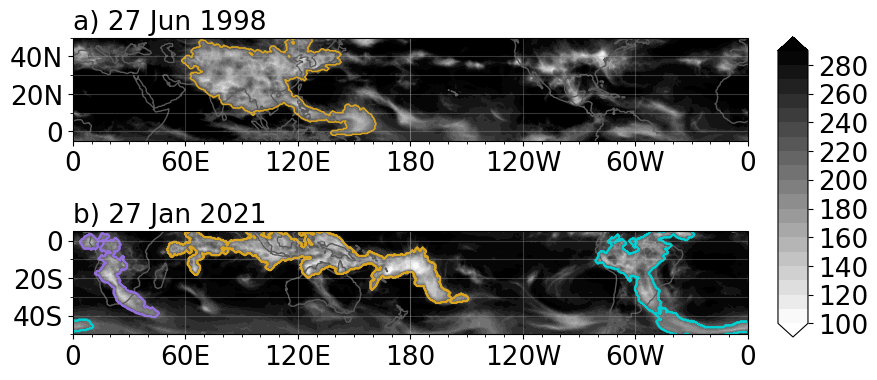

In [5]:
from matplotlib import colors


set_fontsize(size=19)
fig, ax = plt.subplots(
    ncols=1, nrows=2, subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180)}, figsize=(10, 5)
)
cmaps = ['plasma_r', 'viridis', 'PuRd']
colors = ["goldenrod", "darkturquoise", "mediumpurple", "darkorange"]
ax[0].set_title(f"a) {config_copy2['datetime_startdate'].strftime('%d %b %Y')}", loc="left", color="k")
olrfill = ax[0].contourf(clons,lats_nh,daily_variable_nh,transform=ccrs.PlateCarree(),levels=range(100,300,10),cmap="binary",extend="both")
# loop over all the cloud bands of the day in the NH
for idx, icb in enumerate(list_of_cloud_bands_northhemisphere[0]):
    ax[0].contour(
        lons,
        lats_nh,
        icb.cloud_band_array,
        np.ma.masked_where(icb.cloud_band_array == 0, icb.cloud_band_array),
        transform=ccrs.PlateCarree(),
        linewidths=1.3,
        colors=colors[idx]
        # levels=range(4),
        # cmap=cmaps[idx], 
    )
ax[0].set_yticks([0, 20, 40], crs=ccrs.PlateCarree())
ax[0].yaxis.set_minor_locator(MultipleLocator(10))
ax[0].yaxis.set_major_formatter(LatitudeFormatter(degree_symbol=""))
ax[0].set_xticks([0, 60, 120, 180, 240, 300, 359.9999999999], crs=ccrs.PlateCarree())
ax[0].xaxis.set_minor_locator(MultipleLocator(10))
ax[0].xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=False, degree_symbol=""))
ax[0].coastlines(color="#595959")
ax[0].gridlines(draw_labels=False, alpha=0.3)

ax[1].set_title(f"b) {config_copy['datetime_startdate'].strftime('%d %b %Y')}", loc="left", color="k")
ax[1].contourf(clons,lats_sh,daily_variable_sh,transform=ccrs.PlateCarree(),levels=range(100,300,10),cmap="binary",extend="both")

# loop over all the cloud bands of the day in the SH
for idx, icb in enumerate(list_of_cloud_bands_southhemisphere[0]):
    ax[1].contour(
        lons,
        lats_sh,
        icb.cloud_band_array,
        # np.ma.masked_where(icb.cloud_band_array == 0, icb.cloud_band_array),
        transform=ccrs.PlateCarree(),
        linewidths=1,
        colors=colors[idx]
        # levels=range(4),
        # cmap=cmaps[idx], 
    )
ax[1].set_yticks([0,-20, -40], crs=ccrs.PlateCarree())
ax[1].yaxis.set_minor_locator(MultipleLocator(10))
ax[1].yaxis.set_major_formatter(LatitudeFormatter(degree_symbol=""))
ax[1].set_xticks([0, 60, 120, 180, 240, 300, 359.9999999999], crs=ccrs.PlateCarree())
ax[1].xaxis.set_minor_locator(MultipleLocator(10))
ax[1].xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=False, degree_symbol=""))
ax[1].coastlines(color="#595959")
ax[1].gridlines(draw_labels=False, alpha=0.3)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.193, 0.03, 0.6])
fig.colorbar(olrfill, cax=cbar_ax)
# cbar.set_ticks(np.arange(100, 340, 40))

fig.subplots_adjust(wspace=0.01, hspace=0.01)

